# Diabetes classification — Logistic Regression & SVM

This notebook focuses on training and evaluating two classifiers (Logistic Regression and an RBF SVM) on a diabetes dataset. Each code cell is preceded by a short description of what it does.



Written by : Prakhar Shukla (2201CS54)

## Setup — imports and configuration

This cell imports the standard libraries used throughout the notebook.

In [10]:
# Standard imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# For reproducibility
RANDOM_STATE = 42
print('Imports done. Random seed =', RANDOM_STATE)


Imports done. Random seed = 42


## Load dataset

This cell loads the Diabetes Dataset.


In [11]:
local_paths = ['diabetes.csv', './diabetes.csv', '/content/diabetes.csv']
df = None
for p in local_paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f'Loaded local file: {p}')
        break
print('\nDataset shape:', df.shape)
print('\nColumns:', df.columns.tolist())
df.head(8)


Loaded local file: diabetes.csv

Dataset shape: (1000, 14)

Columns: ['ID', 'No_Pation', 'Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS']


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N
5,634,34224,F,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,21.0,N
6,721,34225,F,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,24.0,N
7,421,34227,M,48,4.7,47,4.0,2.9,0.8,0.9,1.6,0.4,24.0,N


## Quick EDA

Show basic information about the dataset: shape, column names, and basic stats.

In [12]:
# Basic EDA
display(df.head())
display(df.describe().T)

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


,count,mean,std,min,25%,50%,75%,max
ID,1000.0,340.500000,2.403977e+02,1.0,125.75,300.5,550.25,800.00
No_Pation,1000.0,270551.408000,3.380758e+06,123.0,24063.75,34395.5,45384.25,75435657.00
AGE,1000.0,53.528000,8.799241e+00,20.0,51.00,55.0,59.00,79.00
Urea,1000.0,5.124743,2.935165e+00,0.5,3.70,4.6,5.70,38.90
Cr,1000.0,68.943000,5.998475e+01,6.0,48.00,60.0,73.00,800.00
HbA1c,1000.0,8.281160,2.534003e+00,0.9,6.50,8.0,10.20,16.00
Chol,1000.0,4.862820,1.301738e+00,0.0,4.00,4.8,5.60,10.30
TG,1000.0,2.349610,1.401176e+00,0.3,1.50,2.0,2.90,13.80
HDL,1000.0,1.204750,6.604136e-01,0.2,0.90,1.1,1.30,9.90
LDL,1000.0,2.609790,1.115102e+00,0.3,1.80,2.5,3.30,9.90


##Encode non-numerical columns

In [13]:
# Encode 'Gender' column numerically
df['Gender'] = df['Gender'].str.strip()
gender_mapping = {'M': 0, 'F': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

## Preprocessing

Drop obvious ID-like columns, detect the target column (heuristic). Clean target column values.

In [14]:
# Features and target
X = df.drop(columns=['CLASS', 'ID', 'No_Pation']) # Drop identifier columns and original Gender column
y = df['CLASS'].str.strip() # Remove leading/trailing spaces

print('\nClass distribution (CLASS):')
print(y.value_counts()) # Use the cleaned 'y' for value counts
print('\nClass percentages:')
print(y.value_counts(normalize=True).round(3) * 100)
print('\nUnique classes:', y.unique()) # Print unique values to confirm cleaning


Class distribution (CLASS):
CLASS
Y    844
N    103
P     53
Name: count, dtype: int64

Class percentages:
CLASS
Y    84.4
N    10.3
P     5.3
Name: proportion, dtype: float64

Unique classes: ['N' 'P' 'Y']


## Train-test split and scaling

Split data into train and test sets (stratified when possible) and scale features with StandardScaler.
Impute missing values if present with median imputation.

In [15]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Turn back into DataFrame for convenience
X_train_s = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_s  = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Impute missing values using the median
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train_s_imputed = imputer.fit_transform(X_train_s)
X_test_s_imputed = imputer.transform(X_test_s)

print("\nNaNs after imputation in X_train_s_imputed:\n", np.isnan(X_train_s_imputed).sum())
print("NaNs after imputation in X_test_s_imputed:\n", np.isnan(X_test_s_imputed).sum())

Train shape: (750, 11) Test shape: (250, 11)

NaNs after imputation in X_train_s_imputed:
 0
NaNs after imputation in X_test_s_imputed:
 0


## Train models

Train a Logistic Regression and an RBF SVM.

In [16]:
# Logistic Regression grid
log_clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)
log_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear','lbfgs']}

log_gs = GridSearchCV(log_clf, log_grid, cv=5, scoring='accuracy', n_jobs=-1)
log_gs.fit(X_train_s_imputed, y_train)
print('Logistic best:', log_gs.best_params_, 'CV best score:', round(log_gs.best_score_, 4))

# SVM grid
svm_clf = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
svm_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01, 0.001]}

svm_gs = GridSearchCV(svm_clf, svm_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_gs.fit(X_train_s_imputed, y_train)
print('SVM best:', svm_gs.best_params_, 'CV best score:', round(svm_gs.best_score_, 4))

Logistic best: {'C': 1, 'solver': 'lbfgs'} CV best score: 0.916
SVM best: {'C': 10, 'gamma': 'scale'} CV best score: 0.9347


## Evaluation Report

Compute accuracy, show classification reports and confusion matrices, plot ROC curve.

=== LogisticRegression ===
Accuracy: 0.928

Confusion matrix:
 [[ 23   1   2]
 [  3   2   8]
 [  4   0 207]]

Classification report:
               precision    recall  f1-score   support

           N     0.7667    0.8846    0.8214        26
           P     0.6667    0.1538    0.2500        13
           Y     0.9539    0.9810    0.9673       211

    accuracy                         0.9280       250
   macro avg     0.7958    0.6732    0.6796       250
weighted avg     0.9195    0.9280    0.9148       250



=== SVM ===
Accuracy: 0.952

Confusion matrix:
 [[ 22   1   3]
 [  3   9   1]
 [  2   2 207]]

Classification report:
               precision    recall  f1-score   support

           N     0.8148    0.8462    0.8302        26
           P     0.7500    0.6923    0.7200        13
           Y     0.9810    0.9810    0.9810       211

    accuracy                         0.9520       250
   macro avg     0.8486    0.8398    0.8437       250
weighted avg     0.9517    0.9520    0

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


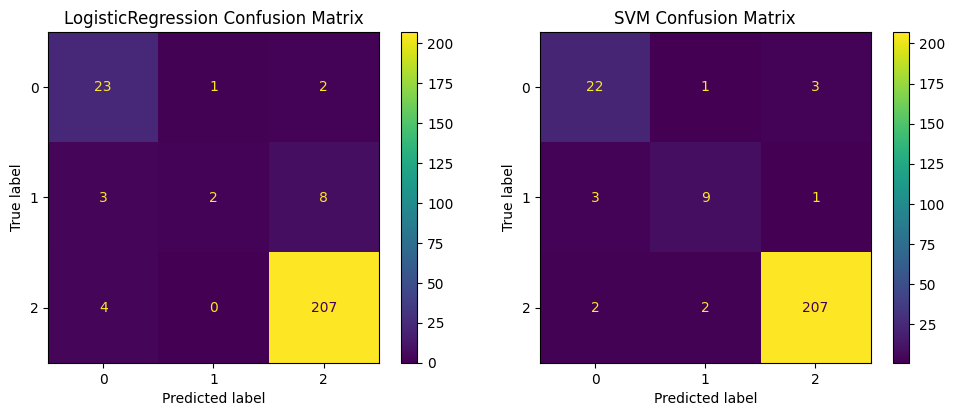

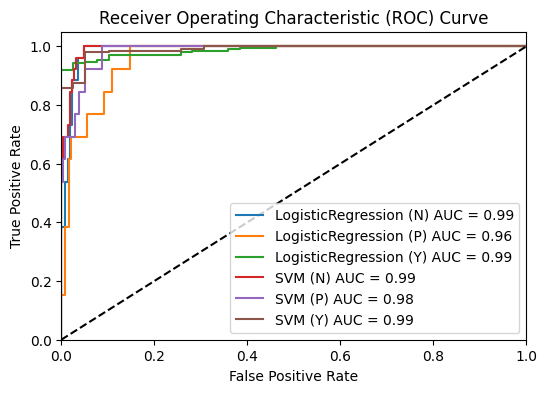

In [17]:
# Evaluate on test set
models = {
    'LogisticRegression': log_gs.best_estimator_,
    'SVM': svm_gs.best_estimator_
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_s)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, digits=4)
    results[name] = dict(acc=acc, cm=cm, cr=cr) # Updated results dictionary
    print(f'=== {name} ===')
    print('Accuracy:', round(acc,4))
    print('\nConfusion matrix:\n', cm)
    print('\nClassification report:\n', cr)
    print('\n')

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, (name, result) in enumerate(results.items()):
    cm = result['cm']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i])
    axes[i].set_title(f'{name} Confusion Matrix')

plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(6, 4))

for name, model in models.items():
    # Remove feature names for prediction
    y_pred_proba = model.predict_proba(X_test_s.values)
    # Assuming 'N', 'P', 'Y' mapping to 0, 1, 2 respectively for roc_curve
    # Need to map y_test to numerical for roc_curve
    y_test_numeric = y_test.map({'N': 0, 'P': 1, 'Y': 2})
    for i, class_name in enumerate(['N', 'P', 'Y']):
        fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba[:, i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} ({class_name}) AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##Approximating Decision Boundaries using PCA

Logistic (PCA) best: {'C': 0.1, 'solver': 'lbfgs'} CV best score: 0.9027
SVM (PCA) best: {'C': 0.1, 'gamma': 'scale'} CV best score: 0.904


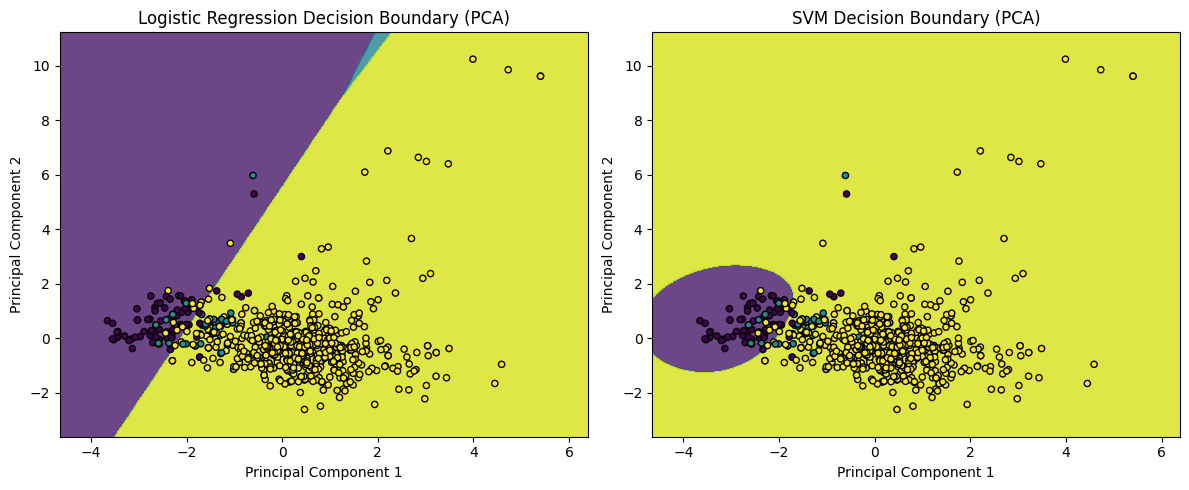

In [18]:
# Visualize decision boundaries in 2D using PCA

# Apply PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_s_imputed)
X_test_pca = pca.transform(X_test_s_imputed)

# Train models on PCA-transformed data
log_clf_pca = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)
log_gs_pca = GridSearchCV(log_clf_pca, log_grid, cv=5, scoring='accuracy', n_jobs=-1)
log_gs_pca.fit(X_train_pca, y_train)
print('Logistic (PCA) best:', log_gs_pca.best_params_, 'CV best score:', round(log_gs_pca.best_score_, 4))

svm_clf_pca = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
svm_grid_pca = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01, 0.001]} # Use the same grid as before
svm_gs_pca = GridSearchCV(svm_clf_pca, svm_grid_pca, cv=5, scoring='accuracy', n_jobs=-1)
svm_gs_pca.fit(X_train_pca, y_train)
print('SVM (PCA) best:', svm_gs_pca.best_params_, 'CV best score:', round(svm_gs_pca.best_score_, 4))

models_pca = {
    'LogisticRegression_PCA': log_gs_pca.best_estimator_,
    'SVM_PCA': svm_gs_pca.best_estimator_
}

# Plot decision boundaries
def plot_decision_boundary(X, y, model, title):
    # Map string labels to numerical for plotting
    class_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
    y_numeric = y.map(class_mapping)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    # Convert predicted labels to numerical
    Z_numeric = np.array([class_mapping[label] for label in Z])
    Z_numeric = Z_numeric.reshape(xx.shape)

    plt.contourf(xx, yy, Z_numeric, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y_numeric, edgecolors='k', marker='o', s=20)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_decision_boundary(X_train_pca, y_train, models_pca['LogisticRegression_PCA'], 'Logistic Regression Decision Boundary (PCA)')

plt.subplot(1, 2, 2)
plot_decision_boundary(X_train_pca, y_train, models_pca['SVM_PCA'], 'SVM Decision Boundary (PCA)')

plt.tight_layout()
plt.show()